**What is transliteration?**

Transliteration refers to the method of mapping from one system of writing to another based on phonetic similarity.

**For example, converting “namaste” to “नमस्ते”.**

**(Remember that “transliteration” is different from “translation”)**

# English to hindi Transliteration on TPUs

In [ ]:
!unzip /content/NEWS2018_DATASET_04.zip

Archive:  /content/NEWS2018_DATASET_04.zip
  inflating: NEWS2018_DATASET_04/NEWS2018_B-HeEn_dev.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_B-HeEn_trn.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_M-EnBa_dev.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_M-EnBa_trn.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_M-EnHi_dev.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_M-EnHi_trn.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_M-EnKa_dev.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_M-EnKa_trn.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_M-EnTa_dev.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_M-EnTa_trn.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_T-EnHe_dev.xml  
  inflating: NEWS2018_DATASET_04/NEWS2018_T-EnHe_trn.xml  


### Loading libraries

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
df = pd.read_xml('/content/NEWS2018_DATASET_04/NEWS2018_M-EnHi_trn.xml')
val = pd.read_xml('/content/NEWS2018_DATASET_04/NEWS2018_M-EnHi_dev.xml')

In [ ]:
name_map = {'SourceName':'English_text','TargetName':'Hindi_text'}
df.rename(columns=name_map,inplace=True)
val.rename(columns=name_map,inplace=True)

In [ ]:
df.sample(5)

,ID,English_text,Hindi_text
8689,8690,nicholas appert award,निकोलस एपर्ट अवार्ड
9013,9014,paise ki gudiya,पैसे की गुड़िया
7003,7004,lakeeren,लकीरें
6359,6360,kala,काला
778,779,ambardekar,आंबर्डेकर


### data preprocessing

In [ ]:
eng_text = df['English_text'].tolist()
hn_text = df['Hindi_text'].tolist()
english_text = []
hindi_text = []
for x,y in zip(eng_text,hn_text):
    a1 = x.split()
    a2 = y.split()
    if len(a1)==len(a2):
        english_text += a1
        hindi_text += a2

In [ ]:
len(english_text),len(hindi_text)

(18996, 18996)

In [ ]:
df_trn = pd.DataFrame(np.column_stack((english_text,hindi_text)),columns=['English_text','Hindi_text'])
df_trn.sample(n=10)

,English_text,Hindi_text
7284,silva,सिल्वा
17400,forts,फोर्ट्‍स
13145,coat,कोट
3953,chetanaa,चेतना
6082,faraar,फरार
15168,bhi,भी
4475,crete,क्रेट
868,akash,आकाश
8368,imran,इमरान
18882,goonasekera,गूरसेकरा


## Training the Model on TPUs, for faster training on large batch sizes

**Model Architecture was taken from this** [Github repo of ainimesh](https://github.com/ainimesh/Hindi-to-English-transliteration-using-deep-Learning-techniques)

In [ ]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
with tpu_strategy.scope():

    # Load data
    data = df_trn.copy()

    # Split data into training and validation sets
    train_data = data.sample(frac=1., random_state=0)

    # Tokenize English_text and Hindi_text
    english_tokenizer = Tokenizer(char_level=True)
    english_tokenizer.fit_on_texts(train_data['English_text'])

    hindi_tokenizer = Tokenizer(char_level=True)
    hindi_tokenizer.fit_on_texts(train_data['Hindi_text'])

    joblib.dump(english_tokenizer,'english_tokenizer')
    joblib.dump(hindi_tokenizer,'hindi_tokenizer')

    # Convert text to sequences
    train_eng_sequences = english_tokenizer.texts_to_sequences(train_data['English_text'])
    train_hin_sequences = hindi_tokenizer.texts_to_sequences(train_data['Hindi_text'])

    # Pad sequences
    train_eng_padded = pad_sequences(train_eng_sequences, padding='post', maxlen=100, truncating='post')
    train_hin_padded = pad_sequences(train_hin_sequences, padding='post', maxlen=100, truncating='post')

    # Define model architecture

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(len(english_tokenizer.word_index)+1, 256, input_length=100),
        #encoder  
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
        tf.keras.layers.RepeatVector(100),
        #decoder
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(512, activation='relu')),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(len(hindi_tokenizer.word_index)+1, activation='softmax'))
    ])


    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            "best_model.h5", save_best_only=True, monitor="val_accuracy",mode='max'
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", factor=0.5, patience=20, min_lr=0.0001,mode='max',
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20, verbose=1)
    ]
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train model
    history = model.fit(train_eng_padded, train_hin_padded, epochs=50, validation_split = 0.15, batch_size=256 , callbacks=callbacks)


Epoch 1/50
64/64 [==============================] - 33s 294ms/step - loss: 0.5078 - accuracy: 0.9293 - val_loss: 0.2743 - val_accuracy: 0.9353 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 7s 113ms/step - loss: 0.2384 - accuracy: 0.9451 - val_loss: 0.2215 - val_accuracy: 0.9459 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 8s 118ms/step - loss: 0.2163 - accuracy: 0.9467 - val_loss: 0.2132 - val_accuracy: 0.9470 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 7s 113ms/step - loss: 0.2113 - accuracy: 0.9472 - val_loss: 0.2083 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 7s 117ms/step - loss: 0.2083 - accuracy: 0.9475 - val_loss: 0.2040 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 7s 114ms/step - loss: 0.2058 - accuracy: 0.9478 - val_loss: 0.2029 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 7s 117ms/step - l

## Making Predictions on the validation Set

In [ ]:
model = tf.keras.models.load_model("best_model.h5")

In [ ]:
# english_tokenizer = joblib.load('english_tokenizer')
# hindi_tokenizer = joblib.load('hindi_tokenizer')

In [ ]:
eng_text = val['English_text'].tolist()
hn_text = val['Hindi_text'].tolist()
english_text = []
hindi_text = []
for x,y in zip(eng_text,hn_text):
    a1 = x.split()
    a2 = y.split()
    if len(a1)==len(a2):
        english_text += a1
        hindi_text += a2
print(len(english_text),len(hindi_text))

1422 1422


In [ ]:
df_val = pd.DataFrame(np.column_stack((english_text,hindi_text)),columns=['English_text','Hindi_text'])
df_val.sample(n=10)

,English_text,Hindi_text
1315,tirap,तिरप
696,jeff,जेफ
899,mera,मेरा
1327,world,वर्ल्ड
1350,university,यूनिवर्सिटी
462,faizullapur,फैज़ुलापुर
1367,environnement,एनवायरमेंट
1077,prometheus,प्रोमिथेउस
1165,ravidas,रविदास
428,dozakh,दोज़ख


In [ ]:
# Make predictions on val set

test_eng_sequences = english_tokenizer.texts_to_sequences(df_val['English_text'])
test_hin_sequences = hindi_tokenizer.texts_to_sequences(df_val['Hindi_text'])

test_eng_padded = pad_sequences(test_eng_sequences, padding='post', maxlen=100, truncating='post')
test_hin_padded = pad_sequences(test_hin_sequences, padding='post', maxlen=100, truncating='post')

preds = model.predict(test_eng_padded)

# Convert predictions to text
predicted_text = []
for pred in preds:
    text = hindi_tokenizer.sequences_to_texts([[np.argmax(p)] for p in pred])
    text1 = "".join(text)
    predicted_text.append(text1)

45/45 [==============================] - 8s 132ms/step


### Model performace on the test set

In [ ]:
model.evaluate(test_eng_padded,test_hin_padded)

45/45 [==============================] - 7s 128ms/step - loss: 0.0790 - accuracy: 0.9815


[0.07896941155195236, 0.9814697504043579]

In [ ]:
df_val['predicted_text'] = predicted_text

In [ ]:
df_val.head(n=20)

,English_text,Hindi_text,predicted_text
0,aachaaryanandana,आचार्यनंदना,आचार्यिंदन
1,aachaarysut,आचार्यसुत,आचार्युुत
2,aacharynandan,आचार्यनंदन,आचार्यंंन
3,aacharynandanaa,आचार्यनंदना,आचार्यनंना
4,aadamkhor,आदमखोर,आदमोो
5,aag,आग,आग
6,aur,और,और
7,shola,शोला,शोला
8,aaj,आज,आज
9,ki,की,की


### Train and Validation plots

In [ ]:
import matplotlib.pyplot as plt

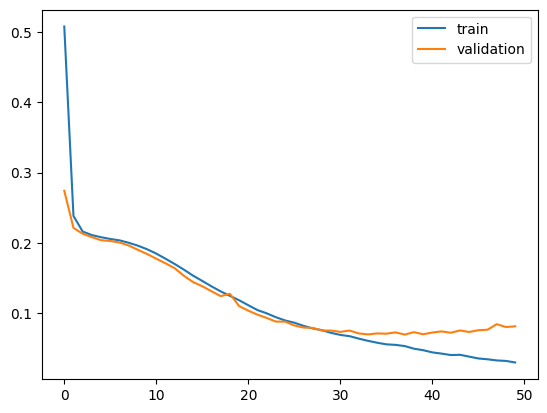

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

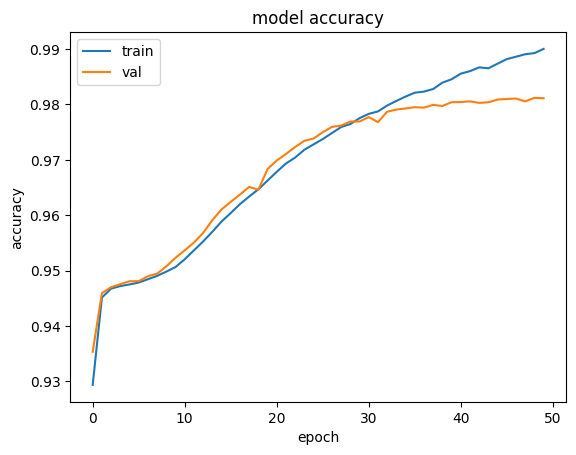

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()